# 1. Get started

In [1]:
# Installing the modules.
!pip install numpy==1.18.5
!pip install scipy==1.4.1
!pip install matplotlib==3.4.2
!pip install protobuf==3.17.3
!pip install scikit-learn==0.24
!pip install -q tensorflow==2.3
!pip install albumentations -q
!pip install pymorphy2
!pip install pymorphy2-dicts


     |████████████████████████████████| 20.1 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cloud 0.1.13 requires tensorflow<3.0,>=1.15.0, which is not installed.
fancyimpute 0.5.5 requires tensorflow, which is not installed.
dask-cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda112, which is not installed.
cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda110, which is not installed.
tensorflow-gpu 2.4.1 requires numpy~=1.19.2, but you have numpy 1.18.5 which is incompatible.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.18.5 which is incompatible.
plotnine 0.8.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1

In [2]:
# Importing modules.
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import albumentations
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy2
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from pylab import rcParams
from itertools import combinations
from scipy.stats import ttest_ind

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.3.0


In [3]:
# Setting the conditions.
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

!pip freeze > requirements.txt

In [4]:
# Defining MAPE function.
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
# Importing datasets.
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# 2. Naive Forecasting (Model 1)  
This model will predict the average price by car model and year of manufacture. We will compare other models with it

In [6]:
# Preparing data for training.
data_train, data_test = train_test_split(
    train,
    test_size=0.15,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [7]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = "model_info == @row[0] and productionDate == @row[1]"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# 3. Exploratory Data Analysis

In [8]:
# Checking the data.
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,...,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,...,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [9]:
# checking for categorial variables
for column in train.columns:
    print(f'There are {len(train[column].unique())} unique values in column {column}')
# will treat all variables with variety less than 20 as categorial

There are 17 unique values in column bodyType
There are 3 unique values in column brand
There are 16 unique values in column color
There are 6147 unique values in column description
There are 48 unique values in column engineDisplacement
There are 146 unique values in column enginePower
There are 4 unique values in column fuelType
There are 2900 unique values in column mileage
There are 41 unique values in column modelDate
There are 118 unique values in column model_info
There are 900 unique values in column name
There are 4 unique values in column numberOfDoors
There are 1628 unique values in column price
There are 38 unique values in column productionDate
There are 6682 unique values in column sell_id
There are 288 unique values in column vehicleConfiguration
There are 4 unique values in column vehicleTransmission
There are 4 unique values in column Владельцы
There are 174 unique values in column Владение
There are 2 unique values in column ПТС
There are 3 unique values in column При

There are only 2 columns with missing values. "Владение" (ownership) column can be dropped, since it is probably strongly correlates with the year of release. Also there is one missing value in the "Владельцы" (number of owners) column. It will be easier to fill it manually.

In [10]:
# Checking the missing values.
train[train['Владельцы'].isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
4994,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2 LTR,360 N12,бензин,160000,1999,S8,...,600000.0,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый


<AxesSubplot:>

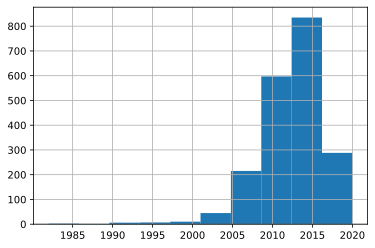

In [11]:
# Checking the frequency distribution.
train[train['Владельцы']=='2\xa0владельца']['productionDate'].hist()

<AxesSubplot:>

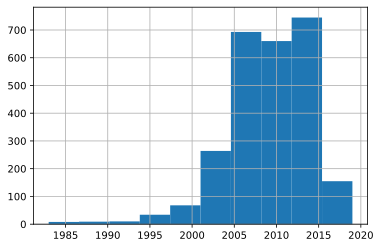

In [12]:
# Checking the frequency distribution.
train[train['Владельцы']=='3 или более']['productionDate'].hist()

Our car was built in 2001, so according to our data, it probably had 3 or more owners. Let's fill in the missing value.

In [13]:
# Filling the missing values.
train.loc[train['Владельцы'].isna()==True, 'Владельцы'] = '3 или более'

In [14]:
# Checking the data.
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,...,4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,...,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый


In [15]:
# Checking for duplicates.
train.duplicated().value_counts()

False    6682
dtype: int64

In [16]:
# Checking for duplicates.
test.duplicated().value_counts()

False    1671
dtype: int64

In [17]:
# Merging the data.
train['sample'] = 1
test['sample'] = 0
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)

In [18]:
# Checking the data.
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,...,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,...,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0


bodyType - car body type, categorical variable.
brand - car brand, categorical variable.
color - car color, categorical variable.
description - vehicle description, text variable, requires processing.
engineDisplacement - car engine displacement, categorical variable, requires processing.
enginePower - car engine power, categorical variable, requires processing.
fuelType - car fuel type, categorical variable.
mileage - car mileage, continuous variable.
modelDate - manufacturing launch year, categorical variable.
model_info - car series, categorical variable.
name - combination of several features, requires processing.
numberOfDoors - number of car doors, categorical variable.
price - target variable.
productionDate - year of manufacture, categorical variable.
sell_id - external id, continuous variable.
vehicleConfiguration - combination of several features, requires processing.
vehicleTransmission - car transmission type, categorical variable.
Владельцы - number of owners, categorical variable.
Владение - ownership time, requires processing and missing values correction.
ПТС - car registration certificate, binary variable.
Привод - car layout, categorical variable.
Руль - car wheel position, categorical variable.

# 3.1 Body Type

<AxesSubplot:>

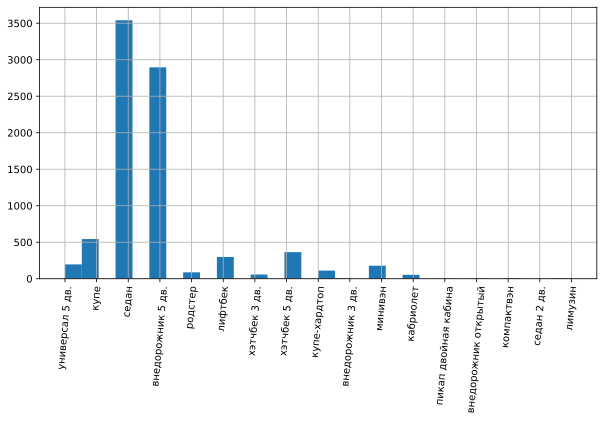

In [19]:
# Checking the data.
data['bodyType'].hist(xrot = 85, figsize = [10,5], bins = 30)

# 3.2 Brand

<AxesSubplot:>

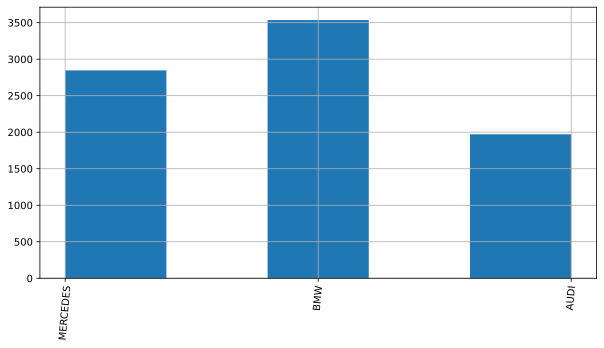

In [20]:
# Checking the data.
data['brand'].hist(xrot = 85, figsize = [10,5], bins = 5)

# 3.3 Сolor

<AxesSubplot:>

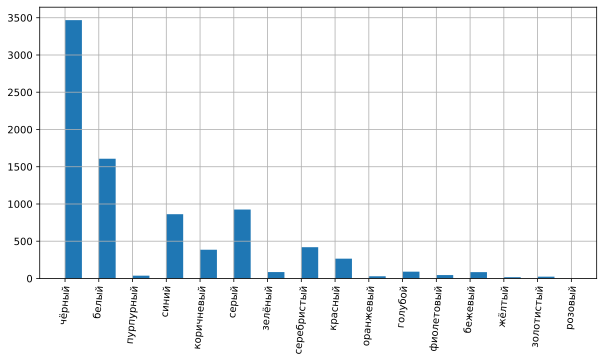

In [21]:
# Checking the data.
data['color'].hist(xrot = 85, figsize = [10,5], bins = 30)

# 3.4 Engine displacement

In [22]:
data['engineDisplacement'].value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
1.4 LTR           106
2.8 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
3.1 LTR            44
2.4 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
0.7 LTR             6
undefined LTR       6
1.9 LTR             5
4.6 LTR             5
5.8 LTR             5
6.6 LTR             5
3.4 LTR             4
4.3 LTR             4
3.8 LTR             3
5.6 LTR   

In [23]:
# Modifying the data.
data.loc[data['engineDisplacement'] == 'undefined LTR', 'engineDisplacement'] = '1.3 LTR'


In [24]:
data['engineDisplacement'].value_counts()

2.0 LTR    2430
3.0 LTR    2349
1.8 LTR     411
1.6 LTR     410
4.4 LTR     329
5.5 LTR     268
3.5 LTR     250
2.5 LTR     248
2.1 LTR     221
4.0 LTR     153
4.7 LTR     137
1.4 LTR     106
2.8 LTR     106
4.2 LTR     103
5.0 LTR      74
1.5 LTR      73
3.2 LTR      60
2.2 LTR      58
4.8 LTR      57
2.9 LTR      50
3.1 LTR      44
2.4 LTR      44
6.2 LTR      40
1.3 LTR      38
6.0 LTR      37
1.2 LTR      33
5.4 LTR      33
2.7 LTR      24
3.6 LTR      23
4.1 LTR      23
1.7 LTR      15
2.3 LTR      14
3.7 LTR      14
5.2 LTR      13
5.9 LTR      11
2.6 LTR       9
0.7 LTR       6
1.9 LTR       5
4.6 LTR       5
5.8 LTR       5
6.6 LTR       5
3.4 LTR       4
4.3 LTR       4
3.8 LTR       3
5.6 LTR       3
6.3 LTR       3
4.9 LTR       2
Name: engineDisplacement, dtype: int64

Now let's convert liters to milliliters. Thus, we will avoid the error when logarithming the value 0.7.

In [25]:
# Modifying the data.
data['engineDisplacement'] = data['engineDisplacement'].str.split().apply(
    lambda s: s[0]
)

data['engineDisplacement'] = data['engineDisplacement'].apply(
    lambda s: float(s)
)

data['engineDisplacement'] = data['engineDisplacement']*1000

<AxesSubplot:>

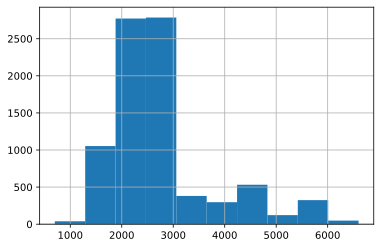

In [26]:
# Checking the frequency distribution.
data['engineDisplacement'].hist(bins = 10)

<AxesSubplot:>

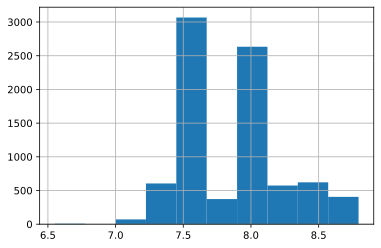

In [27]:
# Normalizing distribution by taking logarithms
np.log(data['engineDisplacement']).hist()

# 3.5 Engine power

In [28]:
# Checking the data.
data['enginePower'].value_counts()

184 N12    759
249 N12    655
190 N12    420
245 N12    355
306 N12    344
          ... 
480 N12      1
174 N12      1
100 N12      1
321 N12      1
329 N12      1
Name: enginePower, Length: 154, dtype: int64

Let's convert the engine power to a numeric feature.

In [29]:
data['enginePower'] = data['enginePower'].str.split().apply(
    lambda s: s[0]
)

data['enginePower'] = data['enginePower'].apply(
    lambda s: float(s)
)

<AxesSubplot:>

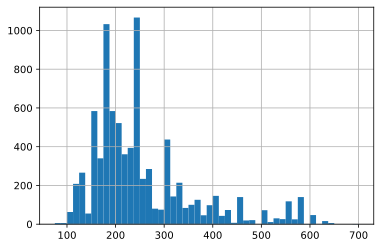

In [30]:
# Checking the frequency distribution.
data['enginePower'].hist(bins=50)

<AxesSubplot:>

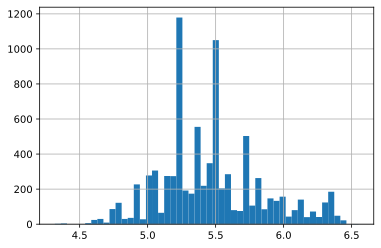

In [31]:
# Normalizing distribution by taking logarithms
np.log(data['enginePower']).hist(bins=50)

# 3.6 Fuel type

In [32]:
# Checking the data.
data['fuelType'].value_counts()

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

# 3.7 Mileage

<AxesSubplot:>

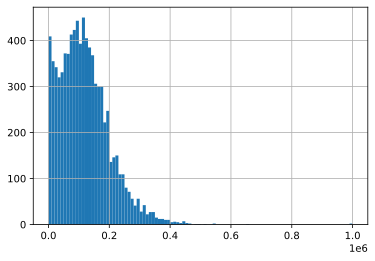

In [33]:
# Checking the frequency distribution.
data['mileage'].hist(bins=100)

<AxesSubplot:>

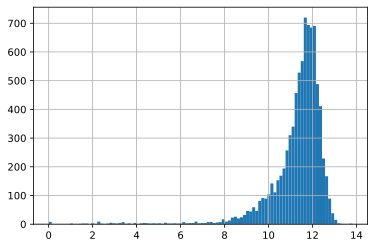

In [34]:
# Normalizing distribution by taking logarithms
np.log(data['mileage']).hist(bins=100)

# 3.8 Production date

<AxesSubplot:>

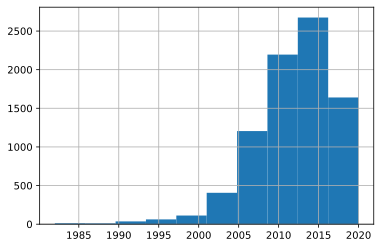

In [35]:
# Checking the frequency distribution.
data['productionDate'].hist()

In [36]:
# Modifying the data.
data['productionDate'] = 2021 - data['productionDate']

<AxesSubplot:>

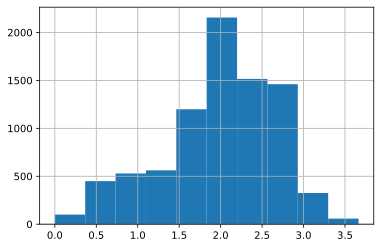

In [37]:
# Checking the frequency distribution.
np.log(data['productionDate']).hist()

# 3.9 Model info

In [38]:
# Checking the data.
data['model_info'].value_counts()

5ER               776
3ER               578
X5                501
E_KLASSE          490
A6                433
                 ... 
COUPE               1
SLC_KLASSE_AMG      1
W201                1
Z8                  1
W123                1
Name: model_info, Length: 122, dtype: int64

There are some strange names in the full list, let's find out what's wrong with them.

In [39]:
# Checking the data.
data[data['model_info'] == '100']['description']

6275    Продаю S4 1994 года, последний год выпуска S4 ...
Name: description, dtype: object

In [40]:
# Checking the data.
data[data['model_info'] == 'COUPE']['description']

1646    Собственник 10 лет в одних руках. Есть вся ист...
Name: description, dtype: object

In [41]:
# Checking the data.
data[data['model_info'] == 'None']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4000.0,510.0,бензин,41000,2014,None,...,1099323364,SEDAN AUTOMATIC 4.0,автоматическая,3 или более,NaN,Дубликат,задний,Левый,1,3700000.0


We found out that '100' = 'S4', 'COUPE' = 'S2', 'None' = 'C_KLASSE_AMG'.

In [42]:
# Modifying the data.
data.loc[data['model_info'] == '100', 'model_info'] = 'S4'
data.loc[data['model_info'] == 'COUPE', 'model_info'] = 'S2'
data.loc[data['model_info'] == 'None', 'model_info'] = 'C_KLASSE_AMG'

# 3.10 Name

In [43]:
# Checking the data.
data['name']

0                    300 3.0 AT (220 л.с.)
1       640d xDrive 3.0d AT (313 л.с.) 4WD
2              325xi 2.5 AT (218 л.с.) 4WD
3                   318i 2.0 AT (136 л.с.)
4       520d xDrive 2.0d AT (190 л.с.) 4WD
                       ...                
8348                320i 2.0 AT (150 л.с.)
8349               520d 2.0d AT (190 л.с.)
8350                318i 2.0 AT (143 л.с.)
8351            Long 3.0 AT (310 л.с.) 4WD
8352             Pullman 6.0 AT (394 л.с.)
Name: name, Length: 8353, dtype: object

This feature duplicates data from other columns. Let's delete it later

# 3.11 Owners

<AxesSubplot:>

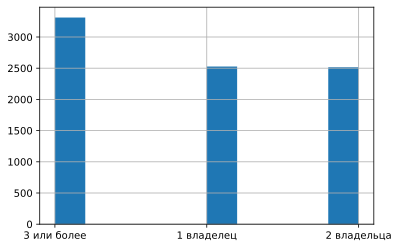

In [44]:
# Checking the frequency distribution.
data['Владельцы'].hist()

In [45]:
# Encoding a categorical variable.
owners_dict = {
    '1\xa0владелец': 1,
    '2\xa0владельца': 2,
    '3 или более': 3
}

data['Владельцы'] = data['Владельцы'].map(owners_dict)

In [46]:
# Checking the data.
data['Владельцы'].value_counts()

3    3312
1    2526
2    2515
Name: Владельцы, dtype: int64

# 3.12 Registration Certificate

<AxesSubplot:>

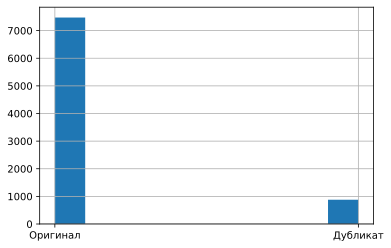

In [47]:
# Checking the frequency distribution.
data['ПТС'].hist()

'ПТС' is, in fact, a binary feature, where 1 is the presence of the original, and 0 is its absence, i.e. a duplicate.

In [48]:
# Encoding a categorical variable.
passport_dict = {
    'Дубликат': 0,
    'Оригинал': 1,
}

data['ПТС'] = data['ПТС'].map(passport_dict)

In [49]:
# Checking the data.
data['ПТС'].value_counts()

1    7474
0     879
Name: ПТС, dtype: int64

# 3.13 Price

<AxesSubplot:>

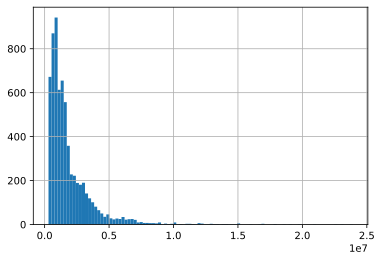

In [50]:
# Checking the frequency distribution.
train['price'].hist(bins=100)

# 4. Feature Engineering

In [51]:
# Creating new features.
popular_colors = [
    'чёрный', 
    'белый', 
    'серый', 
    'синий'
]

rare_colors = [
    'серебристый',
    'коричневый',
    'красный'
]

data['popular_color'] = 0
data['rare_color'] = 0
data['very_rare_color'] = 0

In [52]:
# Creating new features.
counter = 0

for color in data['color']:
    if color in popular_colors:
        data.at[counter,'popular_color'] = 1
        counter += 1
    elif color in rare_colors:
        data.at[counter,'rare_color'] = 1
        counter += 1
    else:
        data.at[counter,'very_rare_color'] = 1
        counter += 1

In [53]:
# Creating new feature.
data['mileage_to_age'] = data['mileage']/data['productionDate']

<AxesSubplot:>

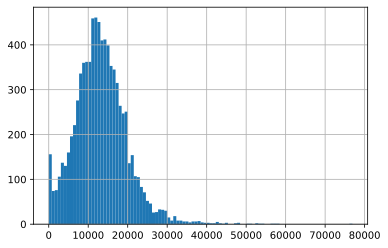

In [54]:
# Checking the frequency distribution.
data['mileage_to_age'].hist(bins=100)

The average MtA is 8-15 thousand km per year. The deviation from this number will be recorded in the binary features "high mileage-to-age ratio" and "low mileage-to-age ratio".

In [55]:
# Creating new features.
data['low_MtA'] = 0
data['high_MtA'] = 0

counter = 0

for MtA in data['mileage_to_age']:
    if MtA < 5000:
        data.at[counter,'low_MtA'] = 1
        counter += 1
    elif MtA > 30000:
        data.at[counter,'high_MtA'] = 1
        counter += 1
    else:
        counter += 1

# 5. Feature Selection

In [56]:
# Checking the data.
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   float64
 5   enginePower           8353 non-null   float64
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,Привод,Руль,sample,price,popular_color,rare_color,very_rare_color,mileage_to_age,low_MtA,high_MtA
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3000.0,220.0,бензин,350000,1984,W124,...,задний,Левый,0,0.0,1,0,0,11666.666667,0,0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3000.0,313.0,дизель,15000,2011,6ER,...,полный,Левый,0,0.0,1,0,0,1875.000000,1,0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2500.0,218.0,бензин,166600,2005,3ER,...,полный,Левый,0,0.0,0,0,1,12815.384615,0,0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2000.0,136.0,бензин,147000,2005,3ER,...,задний,Левый,0,0.0,1,0,0,10500.000000,0,0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2000.0,190.0,дизель,24000,2016,5ER,...,полный,Левый,0,0.0,1,0,0,12000.000000,0,0


In [57]:
# Checking the data.
data.loc[1]

bodyType                                                             купе
brand                                                                 BMW
color                                                               белый
description             Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
engineDisplacement                                                 3000.0
enginePower                                                         313.0
fuelType                                                           дизель
mileage                                                             15000
modelDate                                                            2011
model_info                                                            6ER
name                                   640d xDrive 3.0d AT (313 л.с.) 4WD
numberOfDoors                                                           2
productionDate                                                          8
sell_id                               

In [58]:
# Creating lists of categories.

categorical_features = [
    'bodyType', 
    'brand', 
    'color',
    'fuelType', 
    'model_info',
    'vehicleTransmission', 
    'Привод'
]

numerical_features = [
    'engineDisplacement',
    'enginePower',
    'mileage', 
    'modelDate', 
    'productionDate',
    'numberOfDoors',
    'Владельцы',
    'mileage_to_age'
]

binary_features = [
    'popular_color',
    'rare_color'
    'very_rare_color', 
    'low_MtA', 
    'high_MtA',
    'ПТС'
]

<AxesSubplot:>

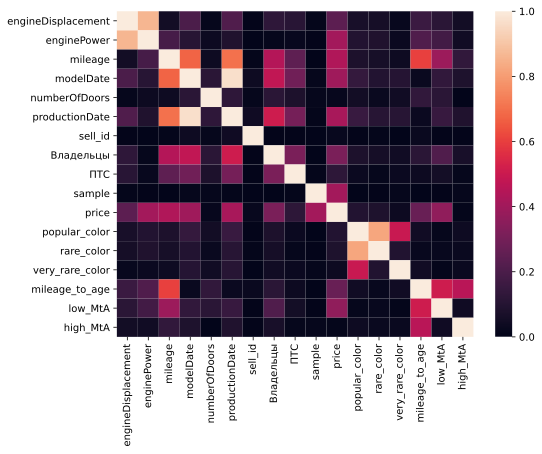

In [59]:
# Checking the correlation matrix.
plt.subplots(figsize=(8,6))
sns.heatmap(data.corr().abs(), vmin=0, vmax=1)

There is a strong correlation between engine displacement and power. Mileage has a strong correlation with age characteristics and the mileage/age ratio. Age characteristics correlate with each other.

In [60]:
# Checking the correlation matrix.
data.corr().abs().sort_values(by='price', ascending=False)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,Владельцы,ПТС,sample,price,popular_color,rare_color,very_rare_color,mileage_to_age,low_MtA,high_MtA
price,0.241048,0.404552,0.436743,0.397267,0.018068,0.417464,0.019779,0.309139,0.118204,0.405771,1.000000,0.090281,0.081155,0.034027,0.269509,0.363177,0.011580
mileage,0.049378,0.184616,1.000000,0.672522,0.038435,0.702970,0.010300,0.444289,0.245004,0.003900,0.436743,0.074997,0.061223,0.037765,0.601572,0.387977,0.132702
productionDate,0.209931,0.085100,0.702970,0.964919,0.124278,1.000000,0.042841,0.507794,0.298051,0.008146,0.417464,0.150023,0.105450,0.101656,0.027846,0.144646,0.083566
sample,0.009001,0.004199,0.003900,0.011782,0.014501,0.008146,0.000134,0.003877,0.008624,1.000000,0.405771,0.003183,0.005860,0.014577,0.003277,0.004362,0.013423
enginePower,0.860317,1.000000,0.184616,0.101825,0.031772,0.085100,0.000859,0.012214,0.019801,0.004199,0.404552,0.089958,0.084783,0.027894,0.209323,0.175343,0.044136
modelDate,0.195373,0.101825,0.672522,1.000000,0.112091,0.964919,0.038045,0.475524,0.285476,0.011782,0.397267,0.136801,0.092767,0.097896,0.023480,0.132525,0.079163
low_MtA,0.110077,0.175343,0.387977,0.132525,0.110394,0.144646,0.005904,0.209073,0.053009,0.004362,0.363177,0.013798,0.022707,0.010606,0.506134,1.000000,0.039769
Владельцы,0.122053,0.012214,0.444289,0.475524,0.112461,0.507794,0.004910,1.000000,0.311522,0.003877,0.309139,0.075965,0.056501,0.046710,0.113091,0.209073,0.066356
mileage_to_age,0.153173,0.209323,0.601572,0.023480,0.130783,0.027846,0.024568,0.113091,0.032032,0.003277,0.269509,0.043919,0.020602,0.045512,1.000000,0.506134,0.456944
engineDisplacement,1.000000,0.860317,0.049378,0.195373,0.011746,0.209931,0.006186,0.122053,0.105635,0.009001,0.241048,0.063556,0.057748,0.023008,0.153173,0.110077,0.048207


Initially, we left only the most strongly correlated features with the target. This reduced the quality of the model, so we bring back all the features.

Let's check if there is a statistically significant difference in the distribution of features using the Student's test.

In [61]:
# Defining Student's test function.
def get_stat_dif(column):
    cols = train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'], 
                        train.loc[train.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all):
            print('Statistically significant differences were found for the column', column)
            break

In [62]:
# Using the Student's test.
for col in categorical_features:
    get_stat_dif(col)

Statistically significant differences were found for the column bodyType
Statistically significant differences were found for the column brand
Statistically significant differences were found for the column color
Statistically significant differences were found for the column fuelType
Statistically significant differences were found for the column model_info
Statistically significant differences were found for the column vehicleTransmission
Statistically significant differences were found for the column Привод


All features have statistically significant differences.

# 6. Data Pre-processing

In [63]:
# Creating lists of categories.

categorical_features = [
    'bodyType', 
    'brand', 
    'color',
    'fuelType', 
    'model_info',
    'vehicleTransmission', 
    'Привод'
]

numerical_features = [
    'engineDisplacement',
    'enginePower',
    'mileage', 
    'modelDate', 
    'productionDate',
    'numberOfDoors',
    'Владельцы',
    'mileage_to_age'
]

binary_features = [
    'popular_color',
    'rare_color'
    'very_rare_color', 
    'low_MtA', 
    'high_MtA',
    'ПТС'
]

In [64]:
# Defining the preprocessing function.
def preproc_data(df_input):

    # Copying the data.
    df_output = df_input.copy()
    
    # Dropping useless data.
    df_output.drop([
        'description',
        'name',
        'sell_id',
        'vehicleConfiguration',
        'Владение',
        'Руль'
    ], axis = 1, inplace=True)
    
    # Taking the logarithm.
    data['enginePower'] = np.log(data['enginePower'])
    data['mileage'] = np.log(data['mileage'])
    data['engineDisplacement'] = np.log(data['enginePower'])
    data['modelDate'] = np.log(data['mileage'])
    data['productionDate'] = np.log(data['mileage'])
    
    # Data normalization.
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # One-hot encoding.
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    df_output = pd.get_dummies(
        df_output, 
        columns=categorical_features, 
        dummy_na=False
    )
    
    return df_output

In [65]:
# Preprocessing the data
df_preproc = preproc_data(data)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:
# Checking the data.
df_preproc.info()
df_preproc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 183 entries, engineDisplacement to Привод_2
dtypes: float64(9), int64(7), uint8(167)
memory usage: 2.4 MB


,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,ПТС,sample,price,...,model_info_117,model_info_118,model_info_119,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2
0,0.389831,0.2320,0.349999,0.270833,1.000000,0.763158,1.0,1,0,0.0,...,0,0,0,1,0,0,0,1,0,0
1,0.389831,0.3808,0.014999,0.833333,0.000000,0.184211,0.0,1,0,0.0,...,0,0,0,1,0,0,0,0,0,1
2,0.305085,0.2288,0.166599,0.708333,0.000000,0.315789,1.0,1,0,0.0,...,0,0,0,1,0,0,0,0,0,1
3,0.220339,0.0976,0.146999,0.708333,0.666667,0.342105,0.5,1,0,0.0,...,0,0,0,1,0,0,0,1,0,0
4,0.220339,0.1840,0.023999,0.937500,0.666667,0.026316,0.0,1,0,0.0,...,0,0,0,1,0,0,0,0,0,1


# 7. CatBoost 

In [67]:
# Preparing data for training.
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED
)

In [68]:
# CatBoost training.
model = CatBoostRegressor(
    iterations=8000,
    random_seed=RANDOM_SEED,
    eval_metric='MAPE',
    custom_metric=['RMSE', 'MAE'],
    od_wait=500
)
                          
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose_eval=100,
    use_best_model=True
)

test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

Learning rate set to 0.017515
0:	learn: 0.9909245	test: 1.0153402	best: 1.0153402 (0)	total: 54.5ms	remaining: 7m 15s
100:	learn: 0.3538166	test: 0.3558615	best: 0.3558615 (100)	total: 353ms	remaining: 27.6s
200:	learn: 0.2581904	test: 0.2571372	best: 0.2571372 (200)	total: 636ms	remaining: 24.7s
300:	learn: 0.2199636	test: 0.2185047	best: 0.2185047 (300)	total: 914ms	remaining: 23.4s
400:	learn: 0.1987936	test: 0.1984906	best: 0.1984906 (400)	total: 1.2s	remaining: 22.7s
500:	learn: 0.1839483	test: 0.1849490	best: 0.1849490 (500)	total: 1.48s	remaining: 22.2s
600:	learn: 0.1748097	test: 0.1770372	best: 0.1770372 (600)	total: 1.77s	remaining: 21.8s
700:	learn: 0.1684601	test: 0.1713661	best: 0.1713661 (700)	total: 2.06s	remaining: 21.5s
800:	learn: 0.1625615	test: 0.1656847	best: 0.1656847 (800)	total: 2.35s	remaining: 21.2s
900:	learn: 0.1567872	test: 0.1603242	best: 0.1603242 (900)	total: 2.75s	remaining: 21.7s
1000:	learn: 0.1527242	test: 0.1573242	best: 0.1572568 (993)	total: 3.25s

## MAPE at this stage: 12.64% (13.23% - Baseline)

In [69]:
# Submitting the results.
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# 8.Tabular NN

In [70]:
# Checking the data.
X_train.head()

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,ПТС,popular_color,rare_color,...,model_info_117,model_info_118,model_info_119,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2
7320,0.898305,0.7504,0.149999,0.770833,0.666667,0.236842,0.0,1,1,0,...,0,0,0,1,0,0,0,1,0,0
8037,0.220339,0.2720,0.020941,0.937500,1.000000,0.052632,0.0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
4681,0.406780,0.2880,0.133896,0.687500,0.666667,0.368421,1.0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
6014,0.186441,0.1744,0.329999,0.729167,0.666667,0.342105,1.0,1,1,0,...,0,0,0,1,0,0,0,1,0,0
3649,0.389831,0.3808,0.125999,0.833333,0.666667,0.184211,0.0,1,1,0,...,0,0,0,1,0,0,0,0,0,1


Let's add l1-l2 regularization to both dense layers and evaluate how it will affect the quality of the model.

In [71]:
# Creating a neural network.
model = Sequential()

model.add(L.Dense(
    512, 
    input_dim=X_train.shape[1], 
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="relu"
))

model.add(L.Dropout(0.5))

model.add(L.Dense(
    256,
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="relu"
))

model.add(L.Dropout(0.5))

model.add(L.Dense(1, activation="linear"))

In [72]:
# Checking the model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               93184     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 224,769
Trainable params: 224,769
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Compiling the model.
optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(
    loss='MAPE', 
    optimizer=optimizer, 
    metrics=['MAPE']
)

In [74]:
# Setting callbacks.
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=50, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]

In [75]:
# Tabular NN training.
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=10
)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

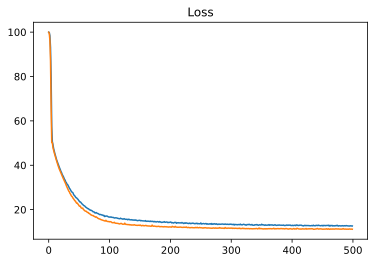

In [76]:
# Checking the plots.
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [77]:
# Saving model + Loading best weights.
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [78]:
# Checking the MAPE.
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.18%


## MAPE at this stage: 11.43% (13.98% - Baseline)

In [79]:
# Submitting the results.
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# 9. Multiple Input NLP

In [80]:
# Checking the data.
data['description']

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

Let's define a lemmatization function and apply it to the "description" feature. The essence of lemmatization is that all words will be reduced to infinitives. In the same function, we will clear the text from characters, which will save us some time.

In [81]:
# Defining the lemmatization function.
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [82]:
# Applying lemmatization.
df_NLP['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)

In [83]:
# Splitting the sample.
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

Let's set the conditions for the NLP model: maximum number of extracted words and maximum length of the sequence.

In [84]:
# Preparing data for training.
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 256

tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [85]:
# Preparing data for training.
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), 
    maxlen=MAX_SEQUENCE_LENGTH
)

text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), 
    maxlen=MAX_SEQUENCE_LENGTH
)

text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), 
    maxlen=MAX_SEQUENCE_LENGTH
)

print(
    text_train_sequences.shape, 
    text_test_sequences.shape, 
    text_sub_sequences.shape
)

(5679, 256) (1003, 256) (1671, 256)


In [86]:
# Checking the data.
print(text_train.iloc[777])
print(text_train_sequences[777])

Оклеили машину на жёлтый чтобы делать бизнес такси но потом придумал и снял .
 Обмен можно с моим доплатой только на х3,х5,land rover , glc и похожие модели и макс 2011г.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0  

In [87]:
# Creating a RNN NLP.
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

In [88]:
# Creating a MLP.
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [89]:
# Combining the networks and head installing.
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)
model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [90]:
# Checking the model.
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

In [91]:
# Compiling the model.
optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(
    loss='MAPE',
    optimizer=optimizer, 
    metrics=['MAPE']
)

In [92]:
# Setting callbacks.
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=10, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]

In [93]:
# Multiple input model training.
history = model.fit(
    [text_train_sequences, X_train],
    y_train,
    batch_size=512,
    epochs=500,
    validation_data=([text_test_sequences, X_test], y_test),
    callbacks=callbacks_list,
    verbose = 50
)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500


KeyboardInterrupt: 

In [ ]:
# Checking the plots.
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
# Saving model + Loading best weights.
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
# Checking the MAPE.
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

MAPE at this stage: 11.7% (14.88% - Baseline)

In [ ]:
# Submitting the results.
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# 10. Multiple Input NLP + Image

In [ ]:
# Checking the images.
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR + 'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
# Defining image array creation function.
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

In [ ]:
# Importing modules.
from albumentations import (
    HorizontalFlip, 
    IAAPerspective, 
    ShiftScaleRotate, 
    CLAHE, 
    RandomRotate90,
    Transpose,
    ShiftScaleRotate, 
    Blur, 
    OpticalDistortion, 
    GridDistortion, 
    HueSaturationValue,
    IAAAdditiveGaussianNoise, 
    GaussNoise, 
    MotionBlur, 
    MedianBlur, 
    IAAPiecewiseAffine,
    IAASharpen, 
    IAAEmboss, 
    RandomBrightnessContrast, 
    Flip, 
    OneOf, 
    Compose
)

In [ ]:
# Setting the conditions for augmentation.
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

In [ ]:
# Checking the images.
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
# Defining augmentation function.
def make_augmentations(images):
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

If we store all the images in memory, we may encounter a shortage of it. With the tf.data.Dataset iterator, we can pass small chunks of data to the fit() method without overloading memory.

In [ ]:
# NLP model part.
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
# Defining NLP and image NN functions.
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(
        tokenize.texts_to_sequences(descriptions), 
        maxlen = MAX_SEQUENCE_LENGTH
    )

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

In [ ]:
# Preparing data for training.
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, 
    X_train, 
    data.description.iloc[X_train.index], 
    y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, 
    X_test, 
    data.description.iloc[X_test.index], 
    y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, 
    X_sub, 
    data.description.iloc[X_sub.index], 
    y_sub
)).map(tf_process_val_dataset_element)

In [ ]:
# Checking for errors.
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [ ]:
# Loading the model.
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (size[1], size[0], 3)
)

efficientnet_output = L.GlobalAveragePooling2D()(
    efficientnet_model.output
)

In [ ]:
# Fine-tuning.
fine_tune_at = len(efficientnet_model.layers)//2

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# Creating a tabular NN.
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# Creating a NLP NN.
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [ ]:
# Combining the networks and head installing.
combinedInput = L.concatenate([
    efficientnet_output, 
    tabular_model.output, 
    nlp_model.output
])

head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[
    efficientnet_model.input, 
    tabular_model.input, 
    nlp_model.input
], outputs=head)

In [ ]:
# Compiling the model.
optimizer = tf.keras.optimizers.Adam(0.005)

model.compile(
    loss='MAPE',
    optimizer=optimizer,
    metrics=['MAPE']
)

In [ ]:
# Setting callbacks.
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=10, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]

In [ ]:
# Multiple input model training.
history = model.fit(
    train_dataset.batch(100),
    epochs=100,
    validation_data=test_dataset.batch(100),
    callbacks=callbacks_list,
    verbose = 2
)

In [ ]:
# Checking the plots.
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
# Saving model + Loading best weights.
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
# Checking the MAPE.
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

MAPE at this stage: 11.83% (14.47% - Baseline)

In [ ]:
# Submitting the results.
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# 11. Blending Predictions

Let's use blending to find the average between the predictions of CatBoost and our neural network with multiple inputs.

In [ ]:
# Checking the MAPE.
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

MAPE at this stage: 11.15% (11.94% - Baseline)

In [ ]:
# Submitting the results.
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# 12. Recap & Conclusions¶

Let's follow the actions taken:

We initialized necessary libraries, set visualization conditions and loaded the dataset.  
We created a naive model as a starting point for assessing the quality of forecasting.  
We conducted an EDA, cleared and processed the tabular information.  
We trained CatBoost and Tabular NN on tabular data, improved the result via regularization and selection of hyperparameters.  
We lemmatized the texts, cleared them of symbols, and trained NLP NN on the received data.  
We have augmented the images and trained Image NN, improving its result via fine-tuning.  
We used blending to average the results.    
At each stage, we managed to improve baseline's performance by at least one percent.  
The following conclusions can be drawn from the results:  

It is necessary to use a naive model to have a reference point for evaluating experiments.  
Reducing the number of features, even if they are correlated with each other, reduces the quality of CatBoost forecasting.  
Taking logarithm of numeric features improves the quality of Tabular NN predictions.  
Regularization has a positive effect on the quality of Tabular NN predictions.  
Lemmatization and symbols clearing improves the quality of NLP NN predictions.  
In the future, when using fine-tuning, it makes sense to look for the optimal mark for freezing the weights.  
tf.data.Dataset iterator helps us to avoids memory overload when working with images.  
Blending consistently helps improve results by averaging forecasts from different models.   